<a href="https://colab.research.google.com/github/Bergu1/neural-network-project/blob/main/neural_network_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importuje biblioteke

In [4]:
import torch
import kagglehub

In [8]:
import os

In [1]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [2]:
from sklearn.model_selection import train_test_split
import shutil
from pathlib import Path

In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
path = kagglehub.dataset_download("chrisfilo/fruit-recognition")
print("Path to dataset files:", path)

100%|██████████| 7.92G/7.92G [06:33<00:00, 21.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/chrisfilo/fruit-recognition/versions/1


In [9]:
path = '/root/.cache/kagglehub/datasets/chrisfilo/fruit-recognition/versions/1'
output_path = '/content/banana_kiwi_orange'
os.makedirs(f"{output_path}", exist_ok=True)
output_path = Path(output_path)
output_path

PosixPath('/content/banana_kiwi_orange')

In [10]:
files = os.listdir(path)
print("Files in the dataset folder:", files)

Files in the dataset folder: ['Tomatoes', 'Orange', 'Carambola', 'Plum', 'Peach', 'Kiwi', 'Banana', 'Pomegranate', 'muskmelon', 'Pitaya', 'Guava', 'Mango', 'Pear', 'Persimmon', 'Apple']


#Usuwanie folderów

In [29]:
for item in os.listdir(output_path):
    item_path = os.path.join(output_path, item)
    if os.path.isdir(item_path):
        shutil.rmtree(item_path)

# Pobieranie danych i kopiowanie do konkretnych utworzonych przez nas folderów
w poniższym przypadku mamy tylko podział na test i train gdybyśmy chcieli mieć podział na test train i validation należało by to zrobić tak:

Najpierw dzielimy dane na zestaw treningowy oraz pozostały (test + walidacja):

**train_images, remaining_images = train_test_split(images, train_size=train_size, random_state=42)**

Następnie dzielimy pozostały zbiór na test i walidację:

**test_images, validation_images = train_test_split(remaining_images, test_size=validation_size, random_state=42)**

Do tych folderów przypisywane są same nazwy obrazków na podstawie których będziemy kopiować dane z datasetu.

In [11]:
categories = ['banana', 'peach', 'orange']
train_size = 800
test_size = 200

In [12]:
os.makedirs(f"{output_path}/train", exist_ok=True)
os.makedirs(f"{output_path}/test", exist_ok=True)

In [13]:
for category in categories:
  category_path = os.path.join(path, category.capitalize())
  train_category_path = os.path.join(output_path, 'train', category)
  test_category_path = os.path.join(output_path, 'test', category)

  os.makedirs(train_category_path, exist_ok=True)
  os.makedirs(test_category_path, exist_ok=True)

  images = os.listdir(category_path)
  train_images, test_images = train_test_split(images, train_size=train_size, test_size=test_size, random_state=42)

  for img in train_images:
      shutil.copy(os.path.join(category_path, img), os.path.join(train_category_path, img))

  for img in test_images:
      shutil.copy(os.path.join(category_path, img), os.path.join(test_category_path, img))

In [14]:
import random
from PIL import Image

In [15]:
random.seed(42)

image_path_list = list(output_path.glob("*/*/*.png"))

Random image path: /content/banana_kiwi_orange/train/peach/Peach001787.png
Image class: peach
Image height: 322
Image width: 480


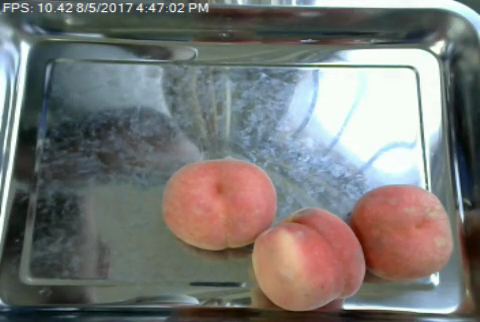

In [16]:
random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

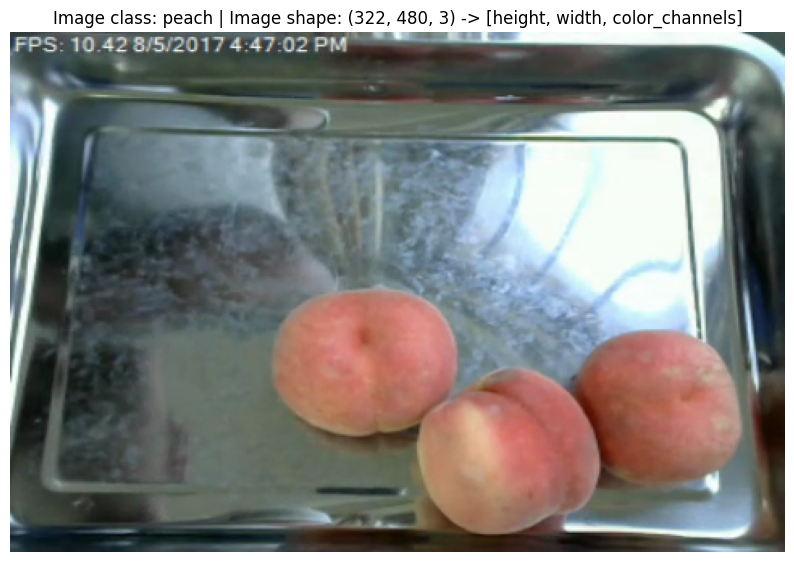

In [17]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [18]:
from torch.utils.data import DataLoader

In [19]:
data_transform = transforms.Compose([
    # zmiana rozmiaru obrazu na 64x64
    transforms.Resize(size=(64, 64)),
    # Losowy obrót obrazu
    transforms.RandomHorizontalFlip(p=0.5), # prawdopodobieństwo obrotu 50%
    # Przekształcenie obrazu w tensor
    transforms.ToTensor()
])

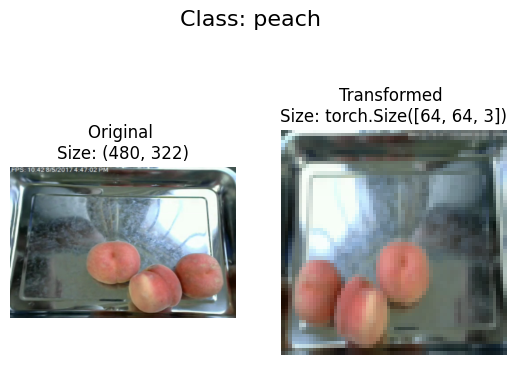

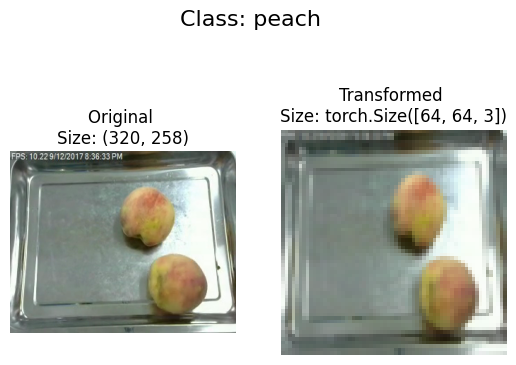

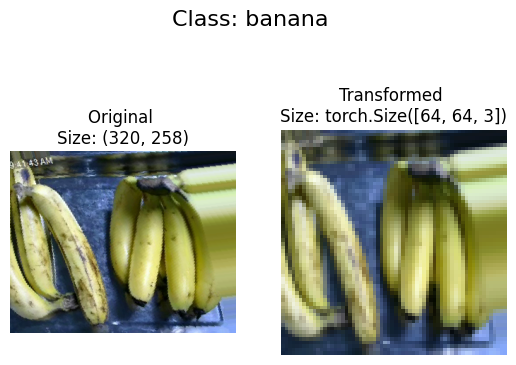

In [20]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    # losujemy trzy losowe obrazki
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        # każdy z obrazków otwieramy jako f
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # każdy obrazek przekształcamy w tensor a następnie zamieniamy kolejność channeli w pytorchu
            # jest colour high i width a my chcemy high width colour
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

In [21]:
def plot_transformed_images(image_paths, transform, seed=42):
    random.seed(seed)
    for image_path in image_paths:
        with Image.open(image_path) as f:
            transform(f).permute(1, 2, 0)

plot_transformed_images(image_path_list,
                        transform=data_transform)

#  Lepsze rozbudowanie zmian obrazków na tensory by lepiej nauczyć naszą sieć

In [22]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])


test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Zmiana obrazków w DataSet

In [23]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=output_path / "train",
                                  transform=train_transforms,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=output_path / "test",
                                 transform=test_transforms)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 2400
    Root location: /content/banana_kiwi_orange/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 600
    Root location: /content/banana_kiwi_orange/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [24]:
# Otrzymanie klas jako lisa
class_names = train_data.classes
class_names

['banana', 'orange', 'peach']

In [25]:
# Otrzymanie klas jako slownik
class_dict = train_data.class_to_idx
class_dict

{'banana': 0, 'orange': 1, 'peach': 2}

In [26]:
len(train_data), len(test_data)

(2400, 600)

In [27]:
img, label = train_data[2300][0], train_data[2300][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.2314, 0.2314, 0.2353,  ..., 0.5451, 0.5333, 0.5216],
         [0.2314, 0.2314, 0.2353,  ..., 0.4863, 0.5412, 0.5373],
         [0.2314, 0.2314, 0.2314,  ..., 0.4471, 0.5333, 0.5412],
         ...,
         [0.4980, 0.4980, 0.4980,  ..., 0.4235, 0.4118, 0.4078],
         [0.4745, 0.4745, 0.4745,  ..., 0.4235, 0.4118, 0.4078],
         [0.4549, 0.4549, 0.4549,  ..., 0.4235, 0.4196, 0.4078]],

        [[0.2824, 0.2824, 0.2902,  ..., 0.6078, 0.5922, 0.5843],
         [0.2824, 0.2824, 0.2863,  ..., 0.5529, 0.6000, 0.6000],
         [0.2824, 0.2824, 0.2824,  ..., 0.5216, 0.6000, 0.6078],
         ...,
         [0.5216, 0.5216, 0.5216,  ..., 0.4784, 0.4667, 0.4627],
         [0.4980, 0.4980, 0.4980,  ..., 0.4784, 0.4667, 0.4627],
         [0.4745, 0.4745, 0.4745,  ..., 0.4784, 0.4745, 0.4627]],

        [[0.2824, 0.2824, 0.2902,  ..., 0.6353, 0.6275, 0.6118],
         [0.2824, 0.2824, 0.2863,  ..., 0.5765, 0.6353, 0.6275],
         [0.2824, 0.2824, 0.2824,  ..., 0.54

Original shape: torch.Size([3, 224, 224]) -> [color_channels, height, width]
Image permute shape: torch.Size([224, 224, 3]) -> [height, width, color_channels]


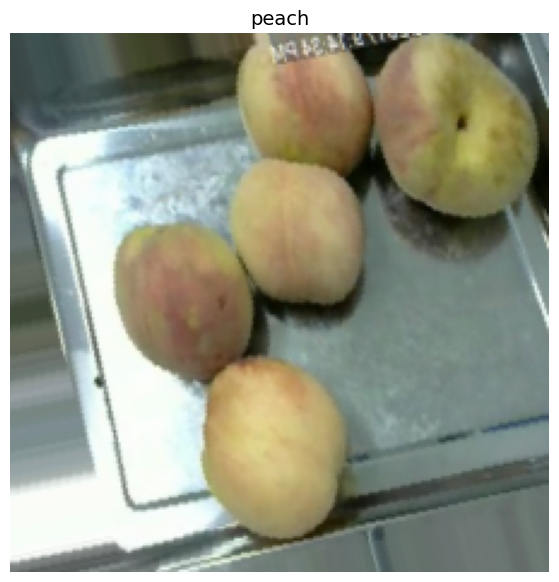

In [28]:
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

# Zmiana obrazka w Dataloader


In [29]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x79e29580e320>,
 <torch.utils.data.dataloader.DataLoader at 0x79e2957b2020>)

In [30]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


#TinyVGG model

In [31]:
from torch import nn

In [33]:
device = "cuda"

In [34]:
class FruitRecognitionModel(nn.Module):
  def __init__ (self, input_shape: int, hidden_units: int, output_shape: int) -> None:
      super().__init__()
      self.conv_block_1 = nn.Sequential(
          nn.Conv2d(in_channels=input_shape,
                    out_channels=hidden_units,
                    kernel_size=3, # okienko 3 na 3 przejścia przez pixele
                    stride=1, # co ile pixeli przechodzisz
                    padding=1, # obramówka obrazu
                    ),
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                      stride=2),
      )
      self.conv_block_2 = nn.Sequential(
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2)
          )
      self.classifier = nn.Sequential(
          nn.Flatten(),
          # Where did this in_features shape come from?
          # It's because each layer of our network compresses and changes the shape of our input data.
          nn.Linear(in_features=hidden_units*16*16,
                    out_features=output_shape)
          )

  def forward(self, x: torch.Tensor):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

torch.manual_seed(42)
model_0 = FruitRecognitionModel(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

FruitRecognitionModel(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)